## H1B Data Study and job opportunities recommendation system

1. Introduction

2. Motivation and Goal

3. Analysis

In [95]:
import os
os.chdir("D:\stackoverflow data\h-1b-visa")

In [96]:
import numpy as np
import pandas as pd
import warnings
import seaborn as sns
import matplotlib.pyplot as plt

In [97]:
data = pd.read_csv('h1b_kaggle.csv')

In [98]:
data.describe()
data.head()

,Unnamed: 0,CASE_STATUS,EMPLOYER_NAME,SOC_NAME,JOB_TITLE,FULL_TIME_POSITION,PREVAILING_WAGE,YEAR,WORKSITE,lon,lat
0,1,CERTIFIED-WITHDRAWN,UNIVERSITY OF MICHIGAN,BIOCHEMISTS AND BIOPHYSICISTS,POSTDOCTORAL RESEARCH FELLOW,N,36067.0,2016.0,"ANN ARBOR, MICHIGAN",-83.743038,42.280826
1,2,CERTIFIED-WITHDRAWN,"GOODMAN NETWORKS, INC.",CHIEF EXECUTIVES,CHIEF OPERATING OFFICER,Y,242674.0,2016.0,"PLANO, TEXAS",-96.698886,33.019843
2,3,CERTIFIED-WITHDRAWN,"PORTS AMERICA GROUP, INC.",CHIEF EXECUTIVES,CHIEF PROCESS OFFICER,Y,193066.0,2016.0,"JERSEY CITY, NEW JERSEY",-74.077642,40.728158
3,4,CERTIFIED-WITHDRAWN,"GATES CORPORATION, A WHOLLY-OWNED SUBSIDIARY O...",CHIEF EXECUTIVES,"REGIONAL PRESIDEN, AMERICAS",Y,220314.0,2016.0,"DENVER, COLORADO",-104.990251,39.739236
4,5,WITHDRAWN,PEABODY INVESTMENTS CORP.,CHIEF EXECUTIVES,PRESIDENT MONGOLIA AND INDIA,Y,157518.4,2016.0,"ST. LOUIS, MISSOURI",-90.199404,38.627003


## One H1B petition has qualities applicationID, case status, employer name, 
## soc name, job title, whether full time position, wages, application year, 
## worksite and the location of the job.

In [99]:
from sklearn.neighbors import KernelDensity
x = np.asarray(data['lon'].tolist())
y = np.asarray(data['lat'].tolist())
index = np.isnan(x) | np.isnan(y) 
x = x[~index]
y = y[~index]
nsamples = min(10000, len(x))
simple_random_sampling = np.random.randint(0,len(x),nsamples)
xs = x[simple_random_sampling]
ys = y[simple_random_sampling]
xy = np.vstack((xs,ys))
z = gaussian_kde(xy)(xy)

    
location = np.column_stack((ys,xs))
val = z

In [100]:
import gmaps
%matplotlib inline

heatmap_layer = gmaps.heatmap_layer(location, val, dissipating = True)
heatmap_layer.max_intensity = 5
heatmap_layer.point_radius = 15
# draw the heatmap into a figure
fig = gmaps.figure()
fig = gmaps.figure(center = [41.850033, -87.6500523], zoom_level = 3)
fig.add_layer(heatmap_layer)

In [101]:
fig

Figure(layout=FigureLayout(height=u'420px'))

How many results can be expected from the H1B application ? 

In [102]:
data['CASE_STATUS'].unique()
# start modification of the data
df = data.copy()

In [103]:
warnings.filterwarnings("ignore")
df.CASE_STATUS[df['CASE_STATUS']=='REJECTED'] = 'DENIED'
df.CASE_STATUS[df['CASE_STATUS']=='INVALIDATED'] = 'DENIED'
df.CASE_STATUS[df['CASE_STATUS']=='PENDING QUALITY AND COMPLIANCE REVIEW - UNASSIGNED'] = 'PENDING'
df.CASE_STATUS[df['CASE_STATUS']=='CERTIFIED-WITHDRAWN'] = 'CERTIFIED'

It is a highly imbalanced data and needs to do further analysis when training a classifier

In [104]:
## Storing non null in df w.r.t. case status
df = df[df['CASE_STATUS'].notnull()]
print(df['CASE_STATUS'].value_counts())

CERTIFIED    2818282
DENIED         94349
WITHDRAWN      89799
PENDING           15
Name: CASE_STATUS, dtype: int64


Find out the number of NAN in the data and remove them

In [105]:
##check count of NAN
count_of_nan = len(df) - df.count()
print('the number of nan in each column is: ' , count_of_nan)

('the number of nan in each column is: ', Unnamed: 0                 0
CASE_STATUS                0
EMPLOYER_NAME             46
SOC_NAME               17721
JOB_TITLE                 30
FULL_TIME_POSITION         2
PREVAILING_WAGE           72
YEAR                       0
WORKSITE                   0
lon                   107242
lat                   107242
dtype: int64)


In [106]:
df = df[df['CASE_STATUS'].notnull()]
df = df[df['EMPLOYER_NAME'].notnull()]
df = df[df['SOC_NAME'].notnull()]
df = df[df['JOB_TITLE'].notnull()]
df = df[df['FULL_TIME_POSITION'].notnull()]
df = df[df['PREVAILING_WAGE'].notnull()]
# Dropping lat and lon columns
if 'lat' in df:
    df = df.drop('lat', axis = 1)
if 'lon' in df:
    df = df.drop('lon', axis = 1)
count_of_nan = len(df) - df.count()
print('the number of nan in each column is: ' , count_of_nan)

('the number of nan in each column is: ', Unnamed: 0            0
CASE_STATUS           0
EMPLOYER_NAME         0
SOC_NAME              0
JOB_TITLE             0
FULL_TIME_POSITION    0
PREVAILING_WAGE       0
YEAR                  0
WORKSITE              0
dtype: int64)


Create a new column to identify whether the record is filed by a higher education institute or not

In [107]:
df['WHETHER_EMPLOYER_UNIVERSITY'] = np.nan

In [108]:
# to sepearte the data into academia job and not academia job
warnings.filterwarnings("ignore")
df['EMPLOYER_NAME'] = df['EMPLOYER_NAME'].str.lower()
df.WHETHER_EMPLOYER_UNIVERSITY[df['EMPLOYER_NAME'].str.contains('university')] = 'university'
df.WHETHER_EMPLOYER_UNIVERSITY[df['EMPLOYER_NAME'].str.contains('college')] = 'university'
df['WHETHER_EMPLOYER_UNIVERSITY'] = df['WHETHER_EMPLOYER_UNIVERSITY'].replace(np.nan, 'not a university', regex=True)

In [109]:
df['WHETHER_CS'] = np.nan

In [110]:
# to sepearte the data into CS job and not CS job
warnings.filterwarnings("ignore")
df['SOC_NAME'] = df['SOC_NAME'].str.lower()
df.WHETHER_CS[df['SOC_NAME'].str.contains('computer')] = 'CS'
df.WHETHER_CS[df['SOC_NAME'].str.contains('software')] = 'CS'
df.WHETHER_CS[df['SOC_NAME'].str.contains('data')] = 'CS'
df.WHETHER_CS[df['SOC_NAME'].str.contains('programmer')] = 'CS'
df.WHETHER_CS[df['SOC_NAME'].str.contains('developer')] = 'CS'
df.WHETHER_CS[df['SOC_NAME'].str.contains('web')] = 'CS'
df['WHETHER_CS'] = df['WHETHER_CS'].replace(np.nan, 'not a CS job')

In [111]:
## Splitting city and state and capturing state in another variable
df['state'] = df.WORKSITE.str.split(',').str[-1].str.lstrip()

In [112]:
df = df[df.state != 'NA']

In [113]:
df1 = df.copy()

In [114]:
for col in ['CASE_STATUS', 'WHETHER_CS', 'FULL_TIME_POSITION', 'YEAR', 'WHETHER_EMPLOYER_UNIVERSITY', 'state']:
    df1[col] = df1[col].astype('category')

In [115]:
df1.WHETHER_EMPLOYER_UNIVERSITY.unique()
df1.dtypes

Unnamed: 0                        int64
CASE_STATUS                    category
EMPLOYER_NAME                    object
SOC_NAME                         object
JOB_TITLE                        object
FULL_TIME_POSITION             category
PREVAILING_WAGE                 float64
YEAR                           category
WORKSITE                         object
WHETHER_EMPLOYER_UNIVERSITY    category
WHETHER_CS                     category
state                          category
dtype: object

It turns out that at least 2/3 of the job is computer science related

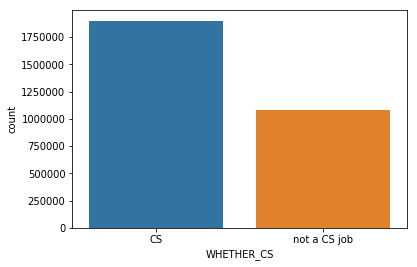

In [116]:
df1.WHETHER_CS.unique()
sns.countplot(x = 'WHETHER_CS',
              data = df1,
              order = df1['WHETHER_CS'].value_counts().index)

Most of the job opportunities are in the industry. But how about the ratio? It is the same as the citizen?

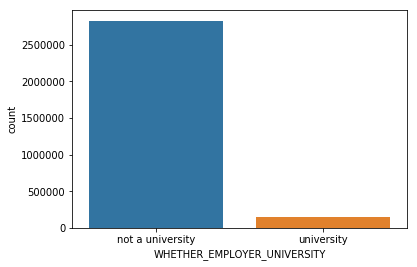

In [117]:
sns.countplot(x = 'WHETHER_EMPLOYER_UNIVERSITY',
              data = df1,
              order = df1['WHETHER_EMPLOYER_UNIVERSITY'].value_counts().index)

## Figure 1 University Based H1B Application Per State From 2011-2016

From the figure 1 we can see that Texas filed the most number of H1B application from 2011 to 2016. And New York is the runner-up in this list. California takes the thrid place. Interestingly, from the data in https://nces.ed.gov/programs/digest/d17/tables/dt17_304.10.asp
California has the most number of enrollment in degree-granting postsecondary institution. Instead, international students/employee are more likely to be hired by employers in the industry in California than any other states in US. 

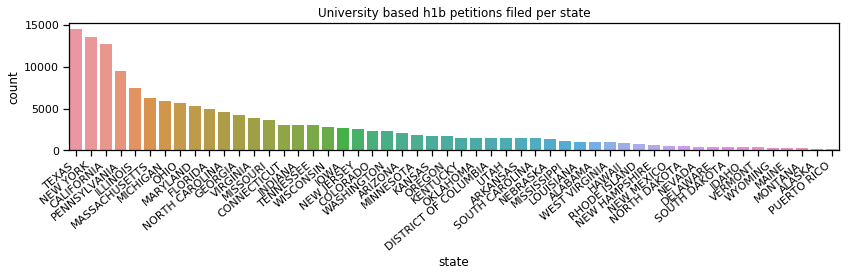

In [118]:
#h1b applied vs year
df2 = df1[df1.WHETHER_EMPLOYER_UNIVERSITY == 'university']
sns.set_context("notebook",font_scale= 1.0)

plt.figure(figsize=(12,4))
plt.title('University based h1b petitions filed per state')
ax = sns.countplot(x = 'state',
              data = df2,
              order = df2['state'].value_counts().index)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout()
plt.show()

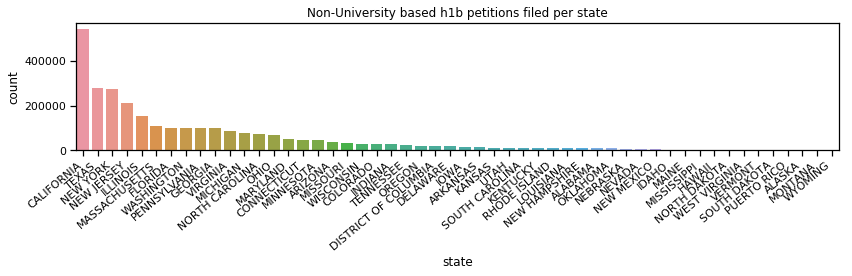

In [119]:
plt.figure(figsize=(12,4))
df3 = df1[df1.WHETHER_EMPLOYER_UNIVERSITY == 'not a university']
plt.title('Non-University based h1b petitions filed per state')
ax = sns.countplot(x = 'state',
              data = df3,
              order = df3['state'].value_counts().index)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout()
plt.show()

## Figure 2 Prediction of Future CS Related Jobs 

We find the H1B petition for CS related jobs from year 2011 to 2016 and plot them in the figure. From the trend we can see that the number of filled petition is increasing all the time. We use a exponential function fit the existing data and extrapolate it to the future, namely year 2017 and 2018. The whole information is shown in Figure 2 below

In [120]:
from scipy.optimize import curve_fit
NumberOFCSJobs_Year = df1[['WHETHER_CS','YEAR']]
temp = NumberOFCSJobs_Year.groupby('YEAR').size()
print(temp)

YEAR
2011.0    351591
2012.0    411552
2013.0    438028
2014.0    514589
2015.0    618043
2016.0    647211
dtype: int64


Text(0,0.5,'CS Related H1B Applications')

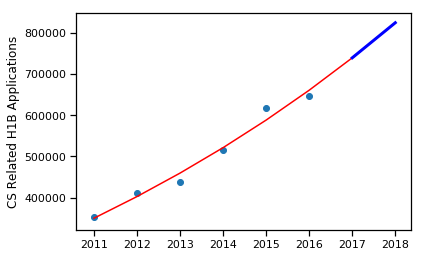

In [121]:
from scipy.optimize import curve_fit
def func(x, a, b, c):
    return a * np.exp(-b * x) + c

year = np.array([0,1,2,3,4,5])
NumberCSJobs = np.array([351591,411552,438028,514589,618043,647211])
popt, pcov = curve_fit(func, year, NumberCSJobs)

yearPred = np.array([0,1,2,3,4,5,6,7])
p1 = plt.plot(yearPred, func(yearPred, *popt), 'r-',label='fit: a=%5.3f, b=%5.3f, c=%5.3f' % tuple(popt))
plt.scatter(year, NumberCSJobs)

yearPred1 = np.array([6,7])
p2 = plt.plot(yearPred1, func(yearPred1, *popt), 'b-',label='fit: a=%5.3f, b=%5.3f, c=%5.3f' % tuple(popt), linewidth = 3.0)

my_xticks = ['2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018']
plt.xticks(year, my_xticks)
plt.xticks(yearPred, my_xticks)
plt.ylabel('CS Related H1B Applications')

The predicted portion is shown in blue and the fitted portion is shown in red. 

## 3. Classification